In [1]:
x=1

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import scipy
import scipy.io

import seaborn as sns
import matplotlib.pyplot as plt

from rpy2.robjects import r
from rpy2.robjects import pandas2ri

import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


In [3]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(Signac)
})


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

# Expressions

In [4]:
rna = sc.read('../../data/neurips-multiome/rna_hvg_batch.h5ad')
rna

AnnData object with n_obs × n_vars = 69249 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'ATAC_gene_activity_var_names', 'Site_colors', 'batch_colors', 'cell_type_colors', 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_umap'
    layers: 'counts'

In [5]:
adata_ = ad.AnnData(rna.layers['counts'])
adata_.obs_names = rna.obs_names
adata_.var_names = rna.var_names
adata_.obs['cell_type'] = rna.obs['cell_type']
adata_.obs['batch'] = rna.obs['batch']

In [6]:
%%R -i adata_
rna = as.Seurat(adata_, counts='X', data=NULL)
rna

An object of class Seurat 
4000 features across 69249 samples within 1 assay 
Active assay: originalexp (4000 features, 0 variable features)


# Peaks

In [7]:
atac = sc.read('../../data/neurips-multiome/atac_hvf.h5ad')
atac

AnnData object with n_obs × n_vars = 69249 × 40002
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay'
    var: 'feature_types', 'gene_id', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'binary', 'counts', 'cpm', 'tf-idf', 'tf-idf-binary', 'tf-idf-counts'

In [8]:
adata_ = ad.AnnData(atac.layers['binary'])
adata_.obs_names = atac.obs_names
adata_.var_names = atac.var_names
adata_.obs['cell_type'] = atac.obs['cell_type']
adata_.obs['batch'] = atac.obs['batch']

In [9]:
%%R -i adata_
peaks = as.Seurat(adata_, counts='X', data=NULL)
peaks

An object of class Seurat 
40002 features across 69249 samples within 1 assay 
Active assay: originalexp (40002 features, 0 variable features)


# Integrate RNA batches

In [10]:
%%R
rna <- RenameAssays(rna, originalexp="RNA")
rna.list <- SplitObject(rna, split.by = "batch")
rna.list <- lapply(X = rna.list, FUN = SCTransform, variable.features.n = 1000)
features <- SelectIntegrationFeatures(object.list = rna.list, nfeatures = 1000)
rna.list <- PrepSCTIntegration(object.list = rna.list, anchor.features = features)

R[write to console]: Renaming default assay from originalexp to RNA

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000 by 6224

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 3 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.644477 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 3 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.725227 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 2 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.044148 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.049458 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3998

  |======================================================================| 100%


R[write to console]: Found 10 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3998 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3998 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.725955 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3998

  |======================================================================| 100%


R[write to console]: Found 6 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3998 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3998 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.655589 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 4 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.152036 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3985

  |======================================================================| 100%


R[write to console]: Found 26 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3985 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3985 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 28.28093 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3826

  |======================================================================| 100%


R[write to console]: Found 34 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3826 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3826 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 29.87746 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4000

  |======================================================================| 100%


R[write to console]: Found 1 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4000 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4000 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.661622 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3996

  |======================================================================| 100%


R[write to console]: Found 6 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3996 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3996 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.828636 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3991

  |======================================================================| 100%


R[write to console]: Found 8 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3991 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3991 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.924596 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 3818

  |======================================================================| 100%


R[write to console]: Found 4 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 3818 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 3818 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 1.210717 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |======================================================================| 100%
R[write to console]: 

R[write to console]: Set default assay to SCT



  |                                                  | 0 % ~calculating   |++++                                              | 8 % ~09s           |++++++++                                          | 15% ~08s           |++++++++++++                                      | 23% ~06s           |++++++++++++++++                                  | 31% ~05s           |++++++++++++++++++++                              | 38% ~05s           |++++++++++++++++++++++++                          | 46% ~04s           |+++++++++++++++++++++++++++                       | 54% ~03s           |+++++++++++++++++++++++++++++++                   | 62% ~03s           |+++++++++++++++++++++++++++++++++++               | 69% ~02s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~02s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~01s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elap

In [11]:
%%R
anchors <- FindIntegrationAnchors(object.list = rna.list, normalization.method = "SCT", 
    anchor.features = features)

R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11988 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9893 anchors



  |+                                                 | 1 % ~01h 10m 49s  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10574 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9579 anchors



  |++                                                | 3 % ~01h 03m 56s  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11033 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10137 anchors



  |++                                                | 4 % ~01h 03m 07s  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10902 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10039 anchors



  |+++                                               | 5 % ~01h 01m 01s  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8533 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7623 anchors



  |++++                                              | 6 % ~58m 22s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 7517 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6776 anchors



  |++++                                              | 8 % ~53m 27s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11693 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10001 anchors



  |+++++                                             | 9 % ~54m 05s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8540 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6861 anchors



  |++++++                                            | 10% ~53m 24s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 7531 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6260 anchors



  |++++++                                            | 12% ~50m 32s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9981 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8595 anchors



  |+++++++                                           | 13% ~48m 43s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9510 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7889 anchors



  |++++++++                                          | 14% ~48m 06s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10589 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8845 anchors



  |++++++++                                          | 15% ~47m 57s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 7721 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6491 anchors



  |+++++++++                                         | 17% ~45m 54s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8746 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7302 anchors



  |+++++++++                                         | 18% ~44m 20s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8073 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6348 anchors



  |++++++++++                                        | 19% ~43m 30s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10723 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9378 anchors



  |+++++++++++                                       | 21% ~43m 07s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9391 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8260 anchors



  |+++++++++++                                       | 22% ~42m 39s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8229 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7340 anchors



  |++++++++++++                                      | 23% ~41m 14s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9030 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8000 anchors



  |+++++++++++++                                     | 24% ~39m 60s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9459 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8209 anchors



  |+++++++++++++                                     | 26% ~39m 24s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8367 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7052 anchors



  |++++++++++++++                                    | 27% ~38m 25s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5902 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5454 anchors



  |+++++++++++++++                                   | 28% ~37m 06s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 6046 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5690 anchors



  |+++++++++++++++                                   | 29% ~35m 57s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5525 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5123 anchors



  |++++++++++++++++                                  | 31% ~34m 31s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5061 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4719 anchors



  |+++++++++++++++++                                 | 32% ~33m 07s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 4731 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4364 anchors



  |+++++++++++++++++                                 | 33% ~31m 57s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5569 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5037 anchors



  |++++++++++++++++++                                | 35% ~30m 47s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5696 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5316 anchors



  |++++++++++++++++++                                | 36% ~29m 39s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5656 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5340 anchors



  |+++++++++++++++++++                               | 37% ~28m 46s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5566 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5098 anchors



  |++++++++++++++++++++                              | 38% ~27m 57s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 4544 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4223 anchors



  |++++++++++++++++++++                              | 40% ~26m 55s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5363 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5051 anchors



  |+++++++++++++++++++++                             | 41% ~25m 56s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5303 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4919 anchors



  |++++++++++++++++++++++                            | 42% ~25m 09s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5716 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5306 anchors



  |++++++++++++++++++++++                            | 44% ~24m 19s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5730 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5360 anchors



  |+++++++++++++++++++++++                           | 45% ~23m 28s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 4006 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 3672 anchors



  |++++++++++++++++++++++++                          | 46% ~22m 26s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12091 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10156 anchors



  |++++++++++++++++++++++++                          | 47% ~22m 12s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9935 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8288 anchors



  |+++++++++++++++++++++++++                         | 49% ~21m 54s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8450 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7110 anchors



  |+++++++++++++++++++++++++                         | 50% ~21m 18s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10409 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8702 anchors



  |++++++++++++++++++++++++++                        | 51% ~20m 44s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11541 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9600 anchors



  |+++++++++++++++++++++++++++                       | 53% ~20m 22s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9636 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7738 anchors



  |+++++++++++++++++++++++++++                       | 54% ~19m 52s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11079 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9160 anchors



  |++++++++++++++++++++++++++++                      | 55% ~19m 19s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5653 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4566 anchors



  |+++++++++++++++++++++++++++++                     | 56% ~18m 32s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 6051 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4785 anchors



  |+++++++++++++++++++++++++++++                     | 58% ~17m 46s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13236 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10233 anchors



  |++++++++++++++++++++++++++++++                    | 59% ~17m 27s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11349 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8677 anchors



  |+++++++++++++++++++++++++++++++                   | 60% ~17m 06s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9621 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7205 anchors



  |+++++++++++++++++++++++++++++++                   | 62% ~16m 33s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10613 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8479 anchors



  |++++++++++++++++++++++++++++++++                  | 63% ~16m 01s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11957 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9428 anchors



  |+++++++++++++++++++++++++++++++++                 | 64% ~15m 37s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9958 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7320 anchors



  |+++++++++++++++++++++++++++++++++                 | 65% ~15m 06s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11538 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8750 anchors



  |++++++++++++++++++++++++++++++++++                | 67% ~14m 34s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 6086 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4294 anchors



  |++++++++++++++++++++++++++++++++++                | 68% ~13m 52s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5966 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4378 anchors



  |+++++++++++++++++++++++++++++++++++               | 69% ~13m 11s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 13385 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10478 anchors



  |++++++++++++++++++++++++++++++++++++              | 71% ~12m 48s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12731 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9414 anchors



  |++++++++++++++++++++++++++++++++++++              | 72% ~12m 23s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 12991 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9606 anchors



  |+++++++++++++++++++++++++++++++++++++             | 73% ~11m 59s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11177 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8397 anchors



  |++++++++++++++++++++++++++++++++++++++            | 74% ~11m 26s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8990 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6733 anchors



  |++++++++++++++++++++++++++++++++++++++            | 76% ~10m 52s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11283 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8587 anchors



  |+++++++++++++++++++++++++++++++++++++++           | 77% ~10m 22s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 9857 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6689 anchors



  |++++++++++++++++++++++++++++++++++++++++          | 78% ~09m 49s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11206 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8339 anchors



  |++++++++++++++++++++++++++++++++++++++++          | 79% ~09m 15s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 6224 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4275 anchors



  |+++++++++++++++++++++++++++++++++++++++++         | 81% ~08m 37s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 5750 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 4123 anchors



  |++++++++++++++++++++++++++++++++++++++++++        | 82% ~07m 59s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11969 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9176 anchors



  |++++++++++++++++++++++++++++++++++++++++++        | 83% ~07m 29s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 15023 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 10921 anchors



  |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~07m 02s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8351 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7114 anchors



  |+++++++++++++++++++++++++++++++++++++++++++       | 86% ~06m 27s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8450 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7364 anchors



  |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~05m 52s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 7388 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6505 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~05m 16s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 6677 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5509 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~04m 39s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 7694 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6328 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~04m 04s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 7811 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5889 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~03m 29s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8107 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6693 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~02m 53s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 4966 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 3955 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~02m 17s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 4973 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 3704 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~01m 42s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8439 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 7172 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~01m 08s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 10263 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 8386 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~34s          

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 11586 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 9626 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=45m 10s


In [12]:
%%R
integrated <- IntegrateData(anchorset = anchors, normalization.method = "SCT")

R[write to console]: Merging dataset 8 into 2

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to con

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to 

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: |

R[write to console]: Integrating data

R[write to console]: Merging dataset 12 13 2 8 3 into 1 4 11 5 

In [13]:
%%R
integrated <- RunPCA(integrated)

R[write to console]: PC_ 1 
Positive:  NAMPT, VCAN, PLXDC2, SLC8A1, ACSL1, LRMDA, SAT1, ANXA1, PLAUR, FCN1 
	   PID1, IRAK3, RBM47, DMXL2, LRRK2, IL1B, MCTP1, ARHGAP26, SAMSN1, DPYD 
	   FGD4, CSF3R, NLRP3, RAB31, NEAT1, TMTC2, SLC11A1, RTN1, CREB5, EREG 
Negative:  BACH2, GNLY, NKG7, CD69, CCL5, IGHM, AFF3, EBF1, SKAP1, CCL4 
	   PRKCH, CD247, IL32, PRF1, BANK1, GZMA, PAX5, HLA-C, TGFBR3, IKZF2 
	   RORA, BCL11B, SYNE2, HBD, CD79B, NCALD, CST7, LTB, THEMIS, INPP4B 
PC_ 2 
Positive:  AFF3, BACH2, IGHM, EBF1, BANK1, PAX5, CD74, FCRL1, PCDH9, CD79B 
	   RALGPS2, HLA-DRA, TCF4, NIBAN3, MS4A1, COL19A1, TCL1A, RUBCNL, OSBPL10, BLK 
	   KHDRBS2, HLA-DQA1, MEF2C, IGHD, PLEKHG1, LINC00926, LINC01374, CDK14, AUTS2, WDFY4 
Negative:  GNLY, NKG7, CCL5, CCL4, PRF1, CD247, GZMA, PRKCH, IL32, TGFBR3 
	   GZMH, AOAH, CST7, LINGO2, FGFBP2, SPON2, GZMM, HBD, CTSW, NCALD 
	   KLRD1, SLC25A37, HLA-C, SAMD3, SLC4A1, FYN, KLRF1, RORA, CD7, HBA1 
PC_ 3 
Positive:  GNLY, NKG7, CCL5, CCL4, PRF1, CD247, GZMA, 

R[write to console]: Warning:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session

R[write to console]: 23:36:19 UMAP embedding parameters a = 0.9922 b = 1.112

R[write to console]: 23:36:19 Read 69249 rows and found 30 numeric columns

R[write to console]: 23:36:19 Using Annoy for neighbor search, n_neighbors = 30

R[write to console]: 23:36:19 Building Annoy index with metric = cosine, n_trees = 50

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *


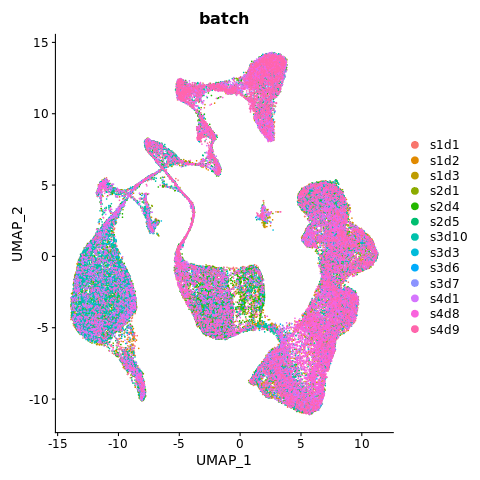

In [14]:
%%R
integrated <- RunUMAP(integrated, dims=1:30)
p1 <- DimPlot(integrated, group.by = "batch")
p1

# Integrate ATAC batches

We follow https://satijalab.org/signac/articles/integrate_atac.html.

In [15]:
%%R
peaks <- RenameAssays(peaks, originalexp='ATAC')

peaks.list <- SplitObject(peaks, split.by = "batch")

peaks.list <- lapply(X = peaks.list, FUN = function(x) {
    x <- RunTFIDF(x, verbose=FALSE)
    x <- FindTopFeatures(x, min.cutoff = 'q0', verbose=FALSE)
})

features <- SelectIntegrationFeatures(object.list = peaks.list)

peaks.list <- lapply(X = peaks.list, FUN = function(x) {
    x <- RunSVD(x, verbose=FALSE)
})

R[write to console]: Renaming default assay from originalexp to ATAC



In [16]:
%%R
anchors <- FindIntegrationAnchors(object.list = peaks.list, reduction = "rlsi", 
    dims = 2:30, anchor.features = features)

R[write to console]: Computing within dataset neighborhoods



  |                                                  | 0 % ~calculating   |++++                                              | 8 % ~24s           |++++++++                                          | 15% ~21s           |++++++++++++                                      | 23% ~16s           |++++++++++++++++                                  | 31% ~13s           |++++++++++++++++++++                              | 38% ~11s           |++++++++++++++++++++++++                          | 46% ~10s           |+++++++++++++++++++++++++++                       | 54% ~08s           |+++++++++++++++++++++++++++++++                   | 62% ~06s           |+++++++++++++++++++++++++++++++++++               | 69% ~04s           |+++++++++++++++++++++++++++++++++++++++           | 77% ~04s           |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~02s           |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elap

R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1061 anchors



  |+                                                 | 1 % ~10m 55s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 895 anchors



  |++                                                | 3 % ~09m 24s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1062 anchors



  |++                                                | 4 % ~09m 04s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 647 anchors



  |+++                                               | 5 % ~08m 35s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 588 anchors



  |++++                                              | 6 % ~08m 26s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 527 anchors



  |++++                                              | 8 % ~07m 56s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 783 anchors



  |+++++                                             | 9 % ~07m 55s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 595 anchors



  |++++++                                            | 10% ~07m 56s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 639 anchors



  |++++++                                            | 12% ~07m 44s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 579 anchors



  |+++++++                                           | 13% ~07m 29s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 428 anchors



  |++++++++                                          | 14% ~07m 22s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 446 anchors



  |++++++++                                          | 15% ~07m 18s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 420 anchors



  |+++++++++                                         | 17% ~07m 04s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 393 anchors



  |+++++++++                                         | 18% ~06m 51s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 338 anchors



  |++++++++++                                        | 19% ~06m 43s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 890 anchors



  |+++++++++++                                       | 21% ~06m 42s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 877 anchors



  |+++++++++++                                       | 22% ~06m 39s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 856 anchors



  |++++++++++++                                      | 23% ~06m 30s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 592 anchors



  |+++++++++++++                                     | 24% ~06m 20s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 666 anchors



  |+++++++++++++                                     | 26% ~06m 14s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 387 anchors



  |++++++++++++++                                    | 27% ~06m 05s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 544 anchors



  |+++++++++++++++                                   | 28% ~05m 54s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 509 anchors



  |+++++++++++++++                                   | 29% ~05m 45s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 463 anchors



  |++++++++++++++++                                  | 31% ~05m 33s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 407 anchors



  |+++++++++++++++++                                 | 32% ~05m 21s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 441 anchors



  |+++++++++++++++++                                 | 33% ~05m 11s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 358 anchors



  |++++++++++++++++++                                | 35% ~05m 01s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 491 anchors



  |++++++++++++++++++                                | 36% ~04m 52s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 322 anchors



  |+++++++++++++++++++                               | 37% ~04m 44s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 302 anchors



  |++++++++++++++++++++                              | 38% ~04m 37s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 284 anchors



  |++++++++++++++++++++                              | 40% ~04m 28s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 353 anchors



  |+++++++++++++++++++++                             | 41% ~04m 19s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 298 anchors



  |++++++++++++++++++++++                            | 42% ~04m 11s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 266 anchors



  |++++++++++++++++++++++                            | 44% ~04m 03s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 352 anchors



  |+++++++++++++++++++++++                           | 45% ~03m 56s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 297 anchors



  |++++++++++++++++++++++++                          | 46% ~03m 47s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 830 anchors



  |++++++++++++++++++++++++                          | 47% ~03m 44s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 724 anchors



  |+++++++++++++++++++++++++                         | 49% ~03m 43s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 679 anchors



  |+++++++++++++++++++++++++                         | 50% ~03m 39s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 595 anchors



  |++++++++++++++++++++++++++                        | 51% ~03m 34s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 740 anchors



  |+++++++++++++++++++++++++++                       | 53% ~03m 31s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 407 anchors



  |+++++++++++++++++++++++++++                       | 54% ~03m 26s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 781 anchors



  |++++++++++++++++++++++++++++                      | 55% ~03m 22s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 455 anchors



  |+++++++++++++++++++++++++++++                     | 56% ~03m 16s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 348 anchors



  |+++++++++++++++++++++++++++++                     | 58% ~03m 10s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1188 anchors



  |++++++++++++++++++++++++++++++                    | 59% ~03m 07s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1024 anchors



  |+++++++++++++++++++++++++++++++                   | 60% ~03m 04s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 954 anchors



  |+++++++++++++++++++++++++++++++                   | 62% ~02m 59s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 723 anchors



  |++++++++++++++++++++++++++++++++                  | 63% ~02m 54s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 905 anchors



  |+++++++++++++++++++++++++++++++++                 | 64% ~02m 50s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 436 anchors



  |+++++++++++++++++++++++++++++++++                 | 65% ~02m 45s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1166 anchors



  |++++++++++++++++++++++++++++++++++                | 67% ~02m 40s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 535 anchors



  |++++++++++++++++++++++++++++++++++                | 68% ~02m 34s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 336 anchors



  |+++++++++++++++++++++++++++++++++++               | 69% ~02m 28s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 953 anchors



  |++++++++++++++++++++++++++++++++++++              | 71% ~02m 23s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1136 anchors



  |++++++++++++++++++++++++++++++++++++              | 72% ~02m 19s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1258 anchors



  |+++++++++++++++++++++++++++++++++++++             | 73% ~02m 15s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1092 anchors



  |++++++++++++++++++++++++++++++++++++++            | 74% ~02m 09s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 627 anchors



  |++++++++++++++++++++++++++++++++++++++            | 76% ~02m 04s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 764 anchors



  |+++++++++++++++++++++++++++++++++++++++           | 77% ~01m 58s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 414 anchors



  |++++++++++++++++++++++++++++++++++++++++          | 78% ~01m 53s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1100 anchors



  |++++++++++++++++++++++++++++++++++++++++          | 79% ~01m 47s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 596 anchors



  |+++++++++++++++++++++++++++++++++++++++++         | 81% ~01m 40s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 296 anchors



  |++++++++++++++++++++++++++++++++++++++++++        | 82% ~01m 34s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 856 anchors



  |++++++++++++++++++++++++++++++++++++++++++        | 83% ~01m 28s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1810 anchors



  |+++++++++++++++++++++++++++++++++++++++++++       | 85% ~01m 22s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 906 anchors



  |+++++++++++++++++++++++++++++++++++++++++++       | 86% ~01m 16s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 872 anchors



  |++++++++++++++++++++++++++++++++++++++++++++      | 87% ~01m 09s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 854 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++     | 88% ~01m 02s      

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 533 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++     | 90% ~55s          

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 634 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++    | 91% ~48s          

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 328 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++   | 92% ~41s          

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 941 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++   | 94% ~34s          

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 472 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++  | 95% ~27s          

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 268 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++++ | 96% ~20s          

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 719 anchors



  |+++++++++++++++++++++++++++++++++++++++++++++++++ | 97% ~13s          

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1176 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 99% ~07s          

R[write to console]: Projecting new data onto SVD

R[write to console]: Projecting new data onto SVD

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 1406 anchors



  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=08m 50s


In [17]:
%%R
peaks <- RunTFIDF(peaks, verbose=FALSE)
peaks <- FindTopFeatures(peaks, min.cutoff = 'q0', verbose=FALSE)
peaks <- RunSVD(peaks, verbose=FALSE)

In [18]:
%%R
integrated_atac <- IntegrateEmbeddings(
  anchorset = anchors,
  reductions = peaks[["lsi"]],
  new.reduction.name = "integrated_lsi",
  dims.to.integrate = 1:30
)

R[write to console]: Merging dataset 8 into 12

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to co

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[writ

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: |

R[write to

R[write to console]: 00:10:59 UMAP embedding parameters a = 0.9922 b = 1.112

R[write to console]: 00:10:59 Read 69249 rows and found 30 numeric columns

R[write to console]: 00:10:59 Using Annoy for neighbor search, n_neighbors = 30

R[write to console]: 00:10:59 Building Annoy index with metric = cosine, n_trees = 50

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

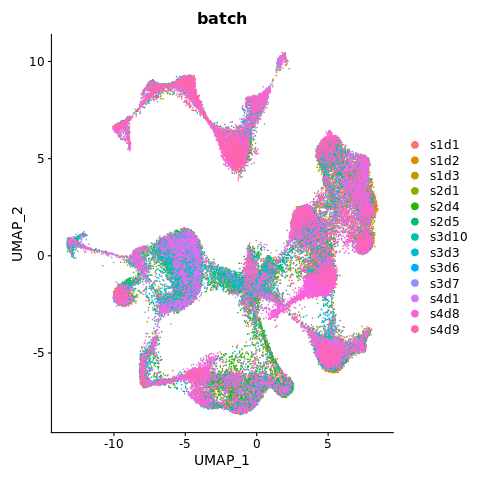

In [19]:
%%R
integrated_atac <- RunUMAP(integrated_atac, dims=1:30, reduction = "integrated_lsi")
p2 <- DimPlot(integrated_atac, group.by = "batch")
p2

# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [20]:
%%R
integrated[["ATAC"]] <- peaks[["ATAC"]]
integrated[["integrated_lsi"]] <- integrated_atac[["integrated_lsi"]]

integrated <- FindMultiModalNeighbors(integrated, reduction.list = list("pca", "integrated_lsi"), 
                              dims.list = list(1:50, 2:30), modality.weight.name = "RNA.weight")

integrated <- RunSPCA(integrated, assay = 'integrated', graph = 'wsnn', npcs = 20)

R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~18s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=35s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~04s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=07s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01m 03s       |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02m 16s
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~07s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=12s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Computing sPCA transformation



In [21]:
%%R -o spca
spca = Embeddings(object = integrated[["spca"]])

In [22]:
adata = sc.AnnData(spca)
adata.obs = adata_.obs
adata

AnnData object with n_obs × n_vars = 69249 × 20
    obs: 'cell_type', 'batch'

In [23]:
%%R -o wnn
wnn <- as.data.frame(summary(integrated@graphs$wknn))

In [24]:
wnn['i'] = wnn['i'] - 1
wnn['j'] = wnn['j'] - 1

In [25]:
adata.obsp['wnn_connectivities'] = scipy.sparse.coo_matrix((wnn['x'], (wnn['i'], wnn['j'])))
adata.obsp['wnn_connectivities'] = scipy.sparse.csr_matrix(adata.obsp['wnn_connectivities'])

In [26]:
adata.write('neurips-multiome-seurat.h5ad')

# Visualize results

In [27]:
sc.pp.neighbors(adata)
adata.obsp['connectivities'] = adata.obsp['wnn_connectivities'].copy()
# delete distances to make sure we are not using anything calculated with sc.pp.neighbors()
del adata.obsp['distances']
sc.tl.umap(adata)

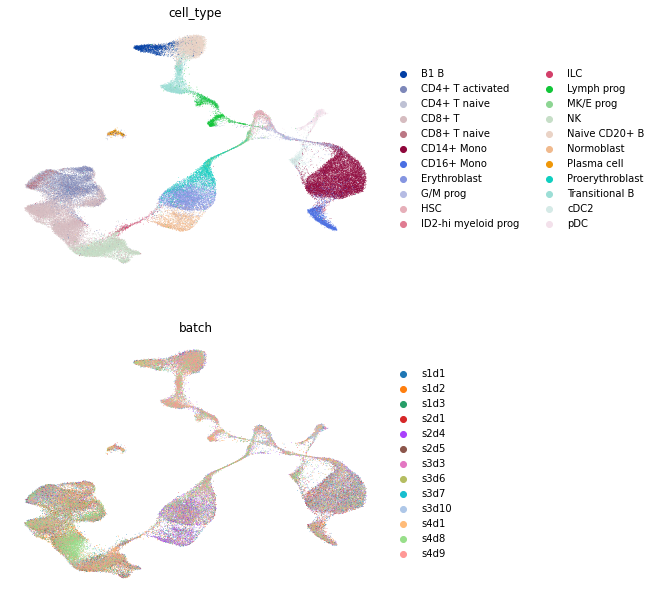

In [28]:
sc.pl.umap(adata, color=['cell_type', 'batch'], ncols=1, frameon=False, save='neurips-multiome-seurat.png')

In [29]:
%%R
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/bridge/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Matrix_1.4-1                Signac_1.7.0               
 [3] sp_1.5-0                    SeuratObject_4.1.0         
 [5] Seurat_4.1.1.9001           SingleCellExperiment_1.16.0
 [7] SummarizedExperiment_1.24.0 Biobase_2.54.0       